In [1]:
import geopandas as gpd
paises = gpd.read_file("../data/colombia_venezuela.geojson")

<Axes: >

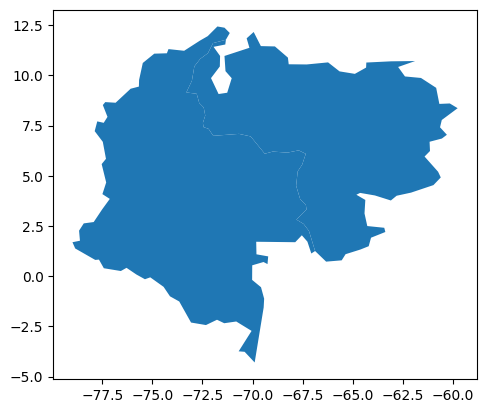

In [2]:
paises.plot()

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 1. Cargar CSV con pandas
df = pd.read_csv("../data/Espeletia_NASADEM_filt.csv")

# 2. Crear geometría a partir de lat/lon
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# 3. Convertir a GeoDataFrame con CRS geográfico
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")  # WGS84

# 4. (opcional) Convertir a CRS proyectado para trabajar con distancias (en metros)
gdf = gdf.to_crs(epsg=3857)


In [5]:
# Buffer de 100 km alrededor de cada punto, luego unirlos en una sola geometría
area_estudio = gdf.buffer(100000).unary_union

C:\Users\danie\AppData\Local\Temp\ipykernel_49252\3041758095.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_estudio = gdf.buffer(100000).unary_union


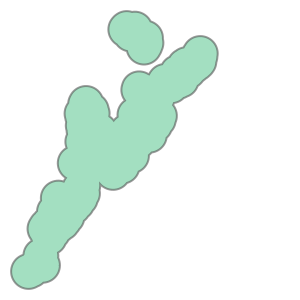

In [6]:
area_estudio

In [7]:
# Buffer de 1 km alrededor de cada punto
exclusion_zone = gdf.buffer(1000).unary_union

# Restar el buffer pequeño del buffer grande
zona_valida = area_estudio.difference(exclusion_zone)


C:\Users\danie\AppData\Local\Temp\ipykernel_49252\1747275898.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  exclusion_zone = gdf.buffer(1000).unary_union


In [8]:
exclusion_zone

In [10]:
zona_valida

In [11]:
import numpy as np
from shapely.geometry import Point

def generar_puntos_aleatorios(poligono, n):
    minx, miny, maxx, maxy = poligono.bounds
    puntos = []
    while len(puntos) < n:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        punto = Point(x, y)
        if poligono.contains(punto):
            puntos.append(punto)
    return puntos

# Generar 1000 puntos pseudo-ausencia
n = 20000
pseudo_pts = generar_puntos_aleatorios(zona_valida, n)


In [20]:
# agregar columna 'y' con presenias [1] en gdf
gdf['y'] = 1

In [24]:
# Pseudo-ausencias
pseudo_gdf = gpd.GeoDataFrame({'y': [0]*n}, geometry=pseudo_pts, crs='EPSG:3857')

In [ ]:
# Verificamos que se agregaron
pseudo_gdf.y

0        0
1        0
2        0
3        0
4        0
        ..
19995    0
19996    0
19997    0
19998    0
19999    0
Name: y, Length: 20000, dtype: int64

In [26]:
# Agregar columnas faltantes con valores vacíos
for col in gdf.columns:
    if col not in pseudo_gdf.columns and col != 'geometry':
        pseudo_gdf[col] = None

# Reordenar columnas
pseudo_gdf = pseudo_gdf[gdf.columns]

# Unir ambos
df_total = gpd.GeoDataFrame(pd.concat([gdf, pseudo_gdf], ignore_index=True), crs='EPSG:3857')


C:\Users\danie\AppData\Local\Temp\ipykernel_49252\3604167362.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_total = gpd.GeoDataFrame(pd.concat([gdf, pseudo_gdf], ignore_index=True), crs='EPSG:3857')


In [30]:
print(df_total.columns)
df_total['y'].describe()

Index(['countryCode', 'elevation_DEM', 'eventDate', 'genus', 'lat', 'locality',
       'lon', 'species', 'stateProvince', '.geo', 'geometry', 'y'],
      dtype='object')


count    42309.000000
mean         0.527287
std          0.499261
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: y, dtype: float64

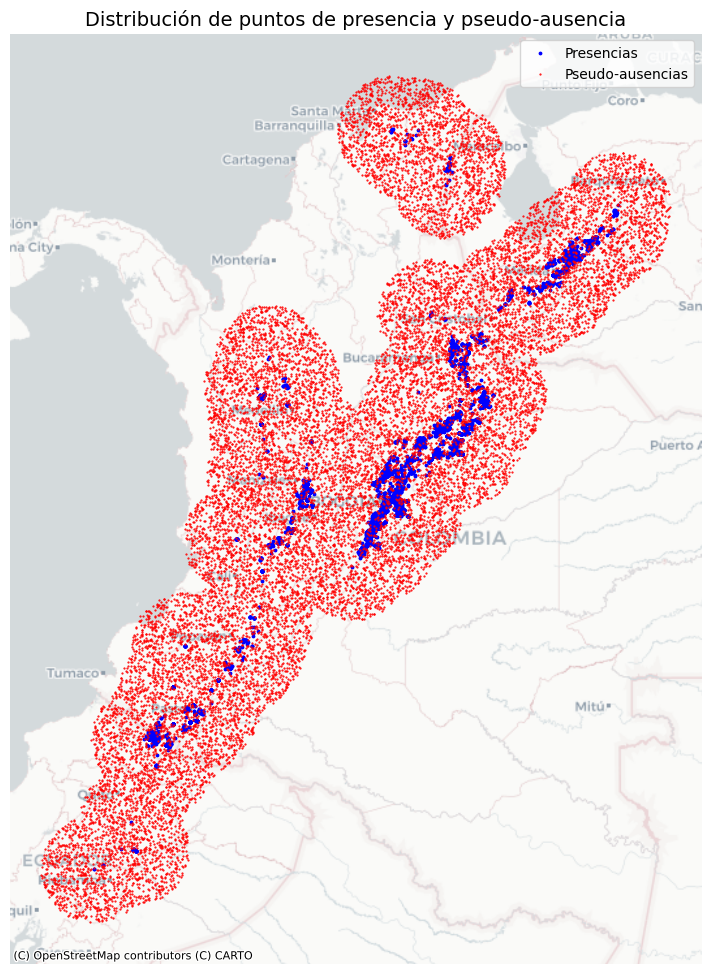

In [59]:
import matplotlib.pyplot as plt
import contextily as ctx

# Separar presencia y ausencia
presencias = df_total[df_total['y'] == 1]
pseudo_ausencias = df_total[df_total['y'] == 0]

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar puntos
presencias.plot(ax=ax, color='blue', markersize=3, label='Presencias')
pseudo_ausencias.plot(ax=ax, color='red', markersize=0.3, label='Pseudo-ausencias')


# limites = gpd.read_file('../data/colombia_venezuela.geojson').to_crs(df_total.crs)
# limites.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=0.5)

# Add basemap
ctx.add_basemap(
    ax, 
    source=ctx.providers.CartoDB.Positron
)

# Estilo
ax.set_title('Distribución de puntos de presencia y pseudo-ausencia', fontsize=14)
ax.set_axis_off()
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Buffer de 1 km alrededor de cada punto
buffers_1km = gdf.buffer(1000)

C:\Users\danie\AppData\Local\Temp\ipykernel_49252\647370017.py:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


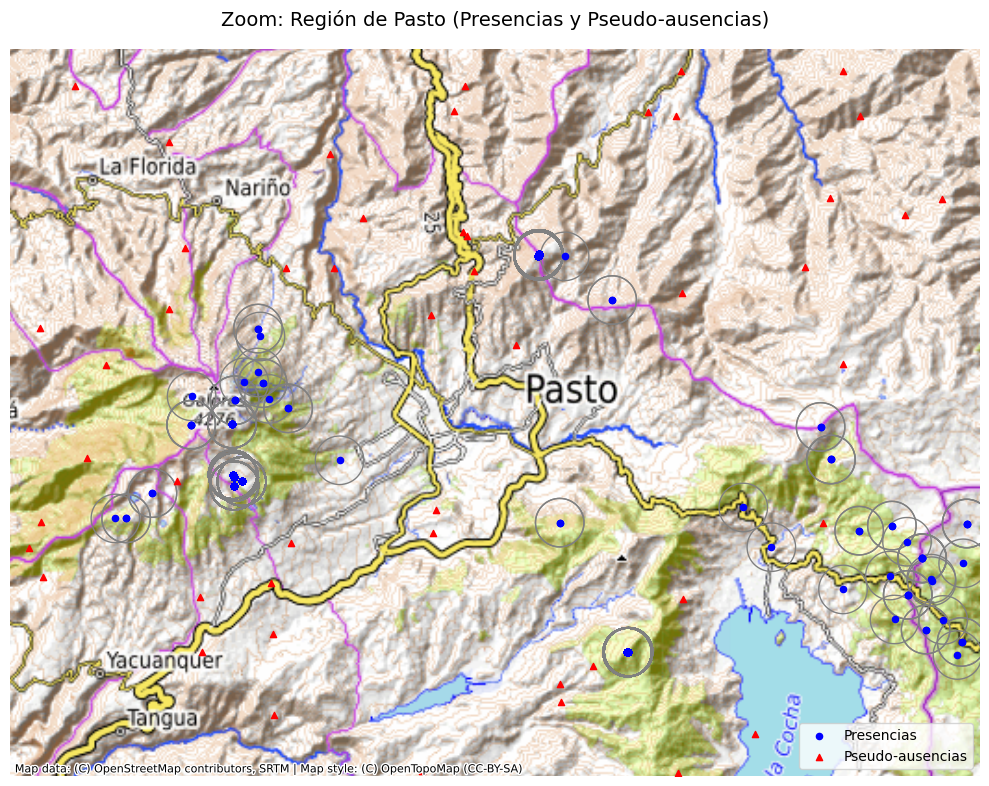

In [61]:
import matplotlib.pyplot as plt
import contextily as ctx

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar buffers con relleno gris claro y sin borde
buffers_1km.plot(
    ax=ax,
    facecolor='none',
    edgecolor='gray',
    alpha=1.0,
    label='Buffer 1km'
)
# Graficar puntos
presencias.plot(ax=ax, color='blue', markersize=20, label='Presencias')
pseudo_ausencias.plot(ax=ax, color='red', marker='^', markersize=20, label='Pseudo-ausencias')

# Zoom en Pasto (EPSG:3857)
ax.set_xlim([-8620000, -8580000])
ax.set_ylim([120000, 150000])

# Agregar mapa base
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)

# Estilo
ax.set_title('Zoom: Región de Pasto (Presencias y Pseudo-ausencias)', fontsize=14, y=1.02)
ax.set_axis_off()
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
# 1. Reproyectar todo a WGS84 (EPSG:4326)
df_total_wgs84 = df_total.to_crs(epsg=4326)

# 2. Extraer coordenadas a columnas
df_total_wgs84['lon'] = df_total_wgs84.geometry.x
df_total_wgs84['lat'] = df_total_wgs84.geometry.y

# 3. Reordenar columnas si lo deseas (ejemplo)
cols = ['y', 'lon', 'lat'] + [c for c in df_total_wgs84.columns if c not in ['y', 'lon', 'lat', 'geometry']]
df_final = df_total_wgs84[cols]


In [ ]:
# 4. Exportar a CSV listo para GEE
# df_final.to_csv('C:/Users/danie/Documents/ESPECIALIZACION-ANALITICA/03_Analisis Geoespacial/Pseudo_aleatorio.csv', index=False, encoding="utf-8")
# df_final.to_csv('../data/Pseudo_aleatorio.csv', index=False, encoding="utf-8")